# Tutorial 1 SpatialEx Translates Histology to Omics at Single-Cell Resolution

## Quantitative Analysis

In [10]:
!python HE_to_omics.py --device 9 --epoch 1000

Namespace(activation='elu', alpha_l=2, attn_drop=0.1, batch_size=4096, beta_l=1, cell_diameter=-1, cluster_label='', decoder='linear', deg4feat=False, device=9, drop_edge_rate=0.0, encoder='hgnn', epoch=1000, file_path='/home/wcy/code/datasets/Xenium/Human_Breast_Cancer_Rep1/cell_feature_matrix.h5', graph_kind='spatial', hidden_dim=512, image_encoder='uni', img_batch_size=64, img_path='/home/wcy/code/datasets/Xenium/Human_Breast_Cancer_Rep1/Xenium_FFPE_Human_Breast_Cancer_Rep1_he_image.ome.tif', impute_file_path='/home/wcy/code/datasets/Xenium/Human_Breast_Cancer_Rep2/cell_feature_matrix.h5', impute_img_path='/home/wcy/code/datasets/Xenium/Human_Breast_Cancer_Rep2/Xenium_FFPE_Human_Breast_Cancer_Rep2_he_image.ome.tif', impute_obs_path='/home/wcy/code/datasets/Xenium/Human_Breast_Cancer_Rep2/cells.csv', impute_sample_name='Human_Breast_Cancer_Rep2', impute_transform_mtx_path='/home/wcy/code/datasets/Xenium/Human_Breast_Cancer_Rep2/Xenium_FFPE_Human_Breast_Cancer_Rep2_he_imagealignment.c

## Qualitative Analysis

### Gene expression visualization of *ESR1*

The red box indicates the sequencing tissue area, whereas its outside only has the H&E image information.

load the package

In [65]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex

import preprocess as pp
selection = pd.read_csv('/home/wcy/code/pyFile/Xenium_modality_impute/inputs/panel/Selection_by_name.csv', index_col=0)
panelA = selection.index[selection['slice1']]
panelB = selection.index[selection['slice2']]

In [65]:
h5_path = '/home/wcy/code/datasets/Xenium/Human_Breast_Cancer_Rep1/cell_feature_matrix.h5'
obs_path = '/home/wcy/code/datasets/Xenium/Human_Breast_Cancer_Rep1/cells.csv'
img_path = '/home/wcy/code/datasets/Xenium/Human_Breast_Cancer_Rep1/Xenium_FFPE_Human_Breast_Cancer_Rep1_he_image.ome.tif'
trans_mtx_path = '/home/wcy/code/datasets/Xenium/Human_Breast_Cancer_Rep1/Xenium_FFPE_Human_Breast_Cancer_Rep1_he_imagealignment.csv'
ref = pp.Read_Xenium(h5_path, obs_path)    
ref = pp.Preprocess_adata(ref, cell_mRNA_cutoff=0, selected_genes=panelB)      

obs = sc.read_h5ad('/home/wcy/code/pyFile/Xenium_modality_impute/inputs/adata/Human_Breast_Cancer_Rep1_uni_resolution64_full.h5ad')
x_prime = pd.read_csv('/home/wcy/code/pyFile/Xenium_modality_impute/version_2/output/adata/150_gene/ours_150_inDirect_panel1b.csv', index_col=0)
ref = ref[x_prime.index.astype(str)]
obs = obs[x_prime.index.astype(str)]
ref.obs = obs.obs.copy()
ref.obsm['image_coor'] = obs.obsm['image_coor']
x_prime = np.maximum(x_prime.values, 0)
adata = ref.copy()
adata.X = x_prime

panelA = np.load('/home/wcy/code/pyFile/Xenium_modality_impute/version_2/output/adata/150_gene/Out_panelB1_indirect.npy')
panelA = np.maximum(panelA, 0)
obs = pd.read_csv('/home/wcy/code/pyFile/Xenium_modality_impute/inputs/adata/HBRC_Rep1_cell_coor.csv', index_col=0)
obs.shape
ref

/home/wcy/anaconda3/envs/torch2X/lib/python3.8/site-packages/anndata/_core/anndata.py:798: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [1, 2, 3, 4, 5]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)
/home/wcy/anaconda3/envs/torch2X/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:138: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_counts'] = number
/home/wcy/anaconda3/envs/torch2X/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


AnnData object with n_obs × n_vars = 161542 × 163
    obs: 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'n_counts', 'image_col', 'image_row'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'log1p'
    obsm: 'spatial', 'image_coor'
    layers: 'raw'

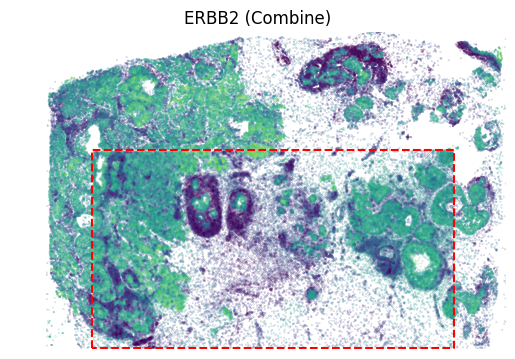

In [26]:
col_min, col_max = ref.obsm['image_coor'][:, 0].min(), ref.obsm['image_coor'][:, 0].max()
row_min, row_max = ref.obsm['image_coor'][:, 1].min(), ref.obsm['image_coor'][:, 1].max()
selection = (obs['image_row'] > row_min) & (obs['image_row'] < row_max) & (obs['image_col'] > col_min) & (obs['image_col'] < col_max)
obs_inner = obs[selection]
var_names = adata.var_names

value = adata[:, 'ERBB2'].X
x, y = ref.obsm['image_coor'][:, 0], ref.obsm['image_coor'][:, 1]
plt.scatter(x, y, c=value, s=0.01)

x = [row_min, row_min, row_max, row_max, row_min]
y = [col_min, col_max, col_max, col_min, col_min]
plt.plot(x, y, color='red', linestyle='--')

gene_idx = np.where(var_names=='ERBB2')[0].item()
value = panelA[:, gene_idx]
x, y = obs['image_col'], obs['image_row']
plt.scatter(y[~selection], x[~selection], c=value[~selection], s=0.01, vmin=0, vmax=value.max())

plt.title('ERBB2 (Combine)')
plt.ylim((0,x.max()))
plt.xlim((0,y.max()))
plt.axis('off')
ax = plt.gca()
ax.set_aspect(1)
plt.savefig('/home/wcy/code/pyFile/Xenium_modality_impute/version_2/output/adata/313_gene/figs/Out_Rep2_ERBB2_combine.png', dpi=300, bbox_inches='tight')

### Visualization of cell type transfer results

In [97]:
cmap = plt.get_cmap("tab20b")  
hex_colors = [to_hex(cmap(i)) for i in range(cmap.N)]

color_dict = {'Stromal':'#6b6ecf', 'Invasive_Tumor':'#f7b6d2', 'DCIS_1':'#7b4173', 'DCIS_2':'#d6616b', 
              'Endothelial':'#c49c94', 'Macrophages_1':'#ff7f0e', 'Macrophages_2':'#ffbb78',
             'Myoepi_ACTA2+':'#EEDD82', 'Myoepi_KRT15+':'#FFD700', 'B_Cells':'#66CD00', 'CD8+_T_Cells':'#9ACD32', 
             'CD4+_T_Cells':'#B3EE3A', 'Prolif_Invasive_Tumor':'#CD3278',
             'Perivascular-Like':'#aa40fc', 'LAMP3+_DCs':'#1f77b4',
             'IRF7+_DCs':'#17becf', 'Mast_Cells':'#279e68'}
color_dict.keys()

dict_keys(['Stromal', 'Invasive_Tumor', 'DCIS_1', 'DCIS_2', 'Endothelial', 'Macrophages_1', 'Macrophages_2', 'Myoepi_ACTA2+', 'Myoepi_KRT15+', 'B_Cells', 'CD8+_T_Cells', 'CD4+_T_Cells', 'Prolif_Invasive_Tumor', 'Perivascular-Like', 'LAMP3+_DCs', 'IRF7+_DCs', 'Mast_Cells'])

(788.5, 29707.5, -852.9000000000001, 19076.9)

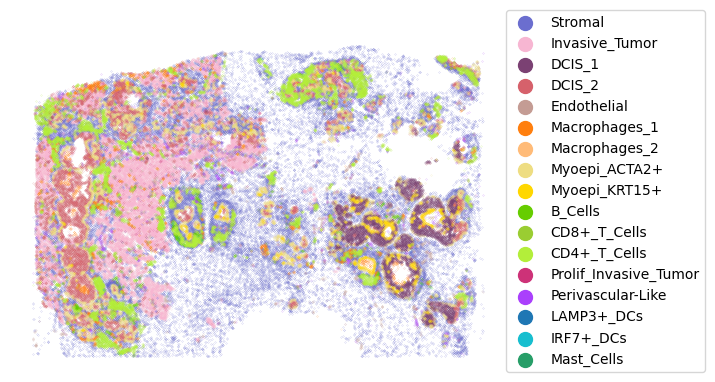

In [98]:
celltype = np.load('/home/wcy/code/pyFile/Xenium_modality_impute/version_2/output/adata/313_gene/Out_celltype.npy')

obs = pd.read_csv('/home/wcy/code/pyFile/Xenium_modality_impute/inputs/adata/HBRC_Rep2_cell_coor.csv', index_col=0)
x, y = obs['image_col'], obs['image_row']
ct_list = list(color_dict.keys())
for i in range(len(ct_list)):
    ct = ct_list[i]
    selection = (celltype == ct)
    plt.scatter(y[selection], x[selection], c=color_dict[ct], s=0.01, label=ct)
plt.legend(bbox_to_anchor=(1, 0), loc=3, borderaxespad=0, markerscale=100)
ax = plt.gca()
ax.set_aspect(1)
plt.axis('off')

### The transferred cell type as well as corresponding marker genes spatial distributions in Slice 2

In [ ]:
x_prime = pd.read_csv('/home/wcy/code/pyFile/Xenium_modality_impute/version_2/output/adata/313_gene/ours_313_panelA2.csv', index_col=0)
obs_names = x_prime.index.astype(str)

In [ ]:
h5_path = '/home/wcy/code/datasets/Xenium/Human_Breast_Cancer_Rep2/cell_feature_matrix.h5'
obs_path = '/home/wcy/code/datasets/Xenium/Human_Breast_Cancer_Rep2/cells.csv'
adata2 = pp.Read_Xenium(h5_path, obs_path)
adata2 = pp.Preprocess_adata(adata2)
adata2 = adata2[obs_names]
adata2_impute = adata2.copy()
adata2_impute.X = x_prime

/home/wcy/anaconda3/envs/torch2X/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/wcy/anaconda3/envs/torch2X/lib/python3.8/contextlib.py:120: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)
/home/wcy/anaconda3/envs/torch2X/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/wcy/anaconda3/envs/torch2X/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


(5610.002365722657, 7589.977175292968, 1740.2284393310547, 3059.2552642822266)

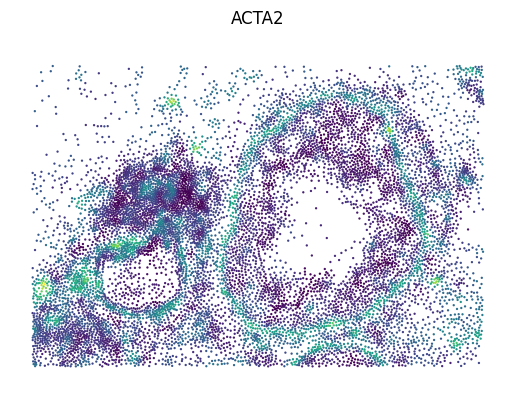

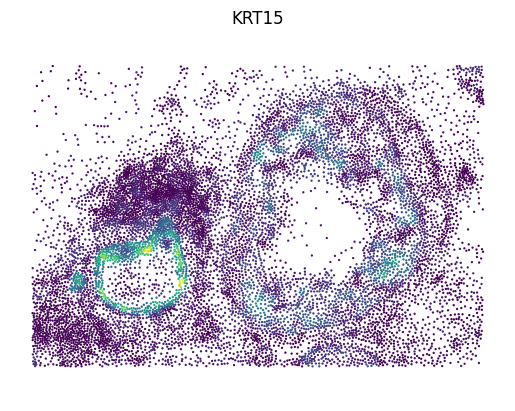

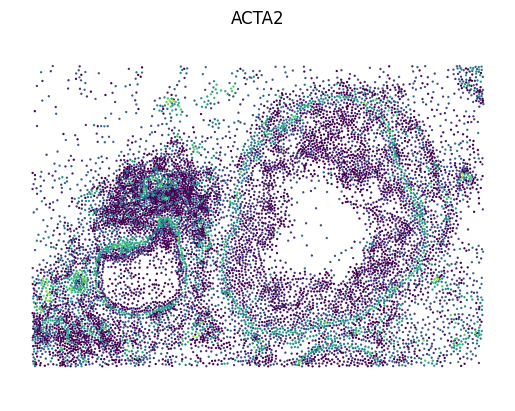

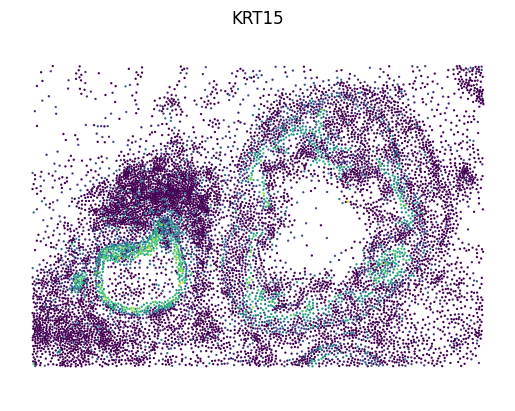

In [139]:
x, y = adata2_impute.obsm['spatial'][:,0], adata2_impute.obsm['spatial'][:, 1]
roi = (x>5700)&(x<7500)&(y>1800)&(y<3000)

adata2_impute = adata2.copy()
adata2_impute.X = x_prime
adata2_impute = adata2_impute[roi]
sc.pl.embedding(adata2_impute, basis='spatial', color='ACTA2', frameon=False, show=False, colorbar_loc=None)
plt.axis('equal')
plt.savefig('/home/wcy/code/pyFile/Xenium_modality_impute/version_2/output/adata/313_gene/figs/roi_ACTA2_ours.png', dpi=300, bbox_inches='tight')
sc.pl.embedding(adata2_impute, basis='spatial', color='KRT15', frameon=False, show=False, colorbar_loc=None)
plt.savefig('/home/wcy/code/pyFile/Xenium_modality_impute/version_2/output/adata/313_gene/figs/roi_KRT15_ours.png', dpi=300, bbox_inches='tight')
plt.axis('equal')

sc.pl.embedding(adata2[roi], basis='spatial', color='ACTA2', frameon=False, show=False, colorbar_loc=None)
plt.savefig('/home/wcy/code/pyFile/Xenium_modality_impute/version_2/output/adata/313_gene/figs/roi_ACTA2_gt.png', dpi=300, bbox_inches='tight')
plt.axis('equal')
sc.pl.embedding(adata2[roi], basis='spatial', color='KRT15', frameon=False, show=False, colorbar_loc=None)
plt.savefig('/home/wcy/code/pyFile/Xenium_modality_impute/version_2/output/adata/313_gene/figs/roi_KRT15_gt.png', dpi=300, bbox_inches='tight')
plt.axis('equal')